This is a workbook dedicated to replicating the Avrami analysis, initially modelled in the PEO50_analysis.ipynb, for analysis of the crystallisation peaks at 45, 47, 53, 55

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
# ------------ settings you can edit ------------
base_dir = "/Users/thomasfish/Desktop/University_Work/II_Materials/P3_Polymer_Crystallisation/DSC_Data"
files = [
    "PEO45_cleaned.csv",
    "PEO47_cleaned.csv",
    "PEO50_cleaned.csv",
    "PEO53_cleaned.csv",
    "PEO55_cleaned.csv",
]
# dataset-specific time windows (min)
time_windows = {
    "PEO45_cleaned.csv": (6, 24),
    "PEO47_cleaned.csv": (5, 35),
    "PEO50_cleaned.csv": (5, 60),
    "PEO53_cleaned.csv": (5, 70),
    "PEO55_cleaned.csv": (0, 120),
}
# Avrami settings
onset_thr = 0.005              # 0.5% crystallised = 0.005 in fraction units
mid_low, mid_high = 0.10, 0.90 # fit only mid-fraction for better linearity

In [11]:
def load_dataset(path):
    df = pd.read_csv(path, header=None, delimiter=r"\s+")
    df.columns = ['Time/m', 'Temperature/C', 'Heat_Flow/mW', 'Area/%']
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna(subset=df.columns).copy()
    df = df[df['Time/m'] >= 0].reset_index(drop=True)  # remove negative time, if any
    return df

def avrami_from_area(t, area_pct, onset_thr=0.005, fit_range=(0.10, 0.90)):
    """Returns (n, Z, x, y, fit_x, fit_y) for Avrami plot using Area/% as F(t)."""
    F = np.clip(area_pct / 100.0, 0.0, 1.0)

    # pick t0 as first time F >= onset_thr
    if np.any(F >= onset_thr):
        idx0 = np.argmax(F >= onset_thr)
        t0 = t[idx0]
    else:
        t0 = t[0]  # fallback

    t_rel = t - t0
    valid = (F > fit_range[0]) & (F < fit_range[1]) & (t_rel > 0)
    if valid.sum() < 5:
        return np.nan, np.nan, np.array([]), np.array([]), np.array([]), np.array([])

    x = np.log(t_rel[valid])
    y = np.log(-np.log(1.0 - F[valid]))

    # linear fit: y = n*x + ln Z
    n, lnZ = np.polyfit(x, y, 1)
    Z = np.exp(lnZ)

    xx = np.linspace(x.min(), x.max(), 200)
    yy = n * xx + lnZ
    return n, Z, x, y, xx, yy


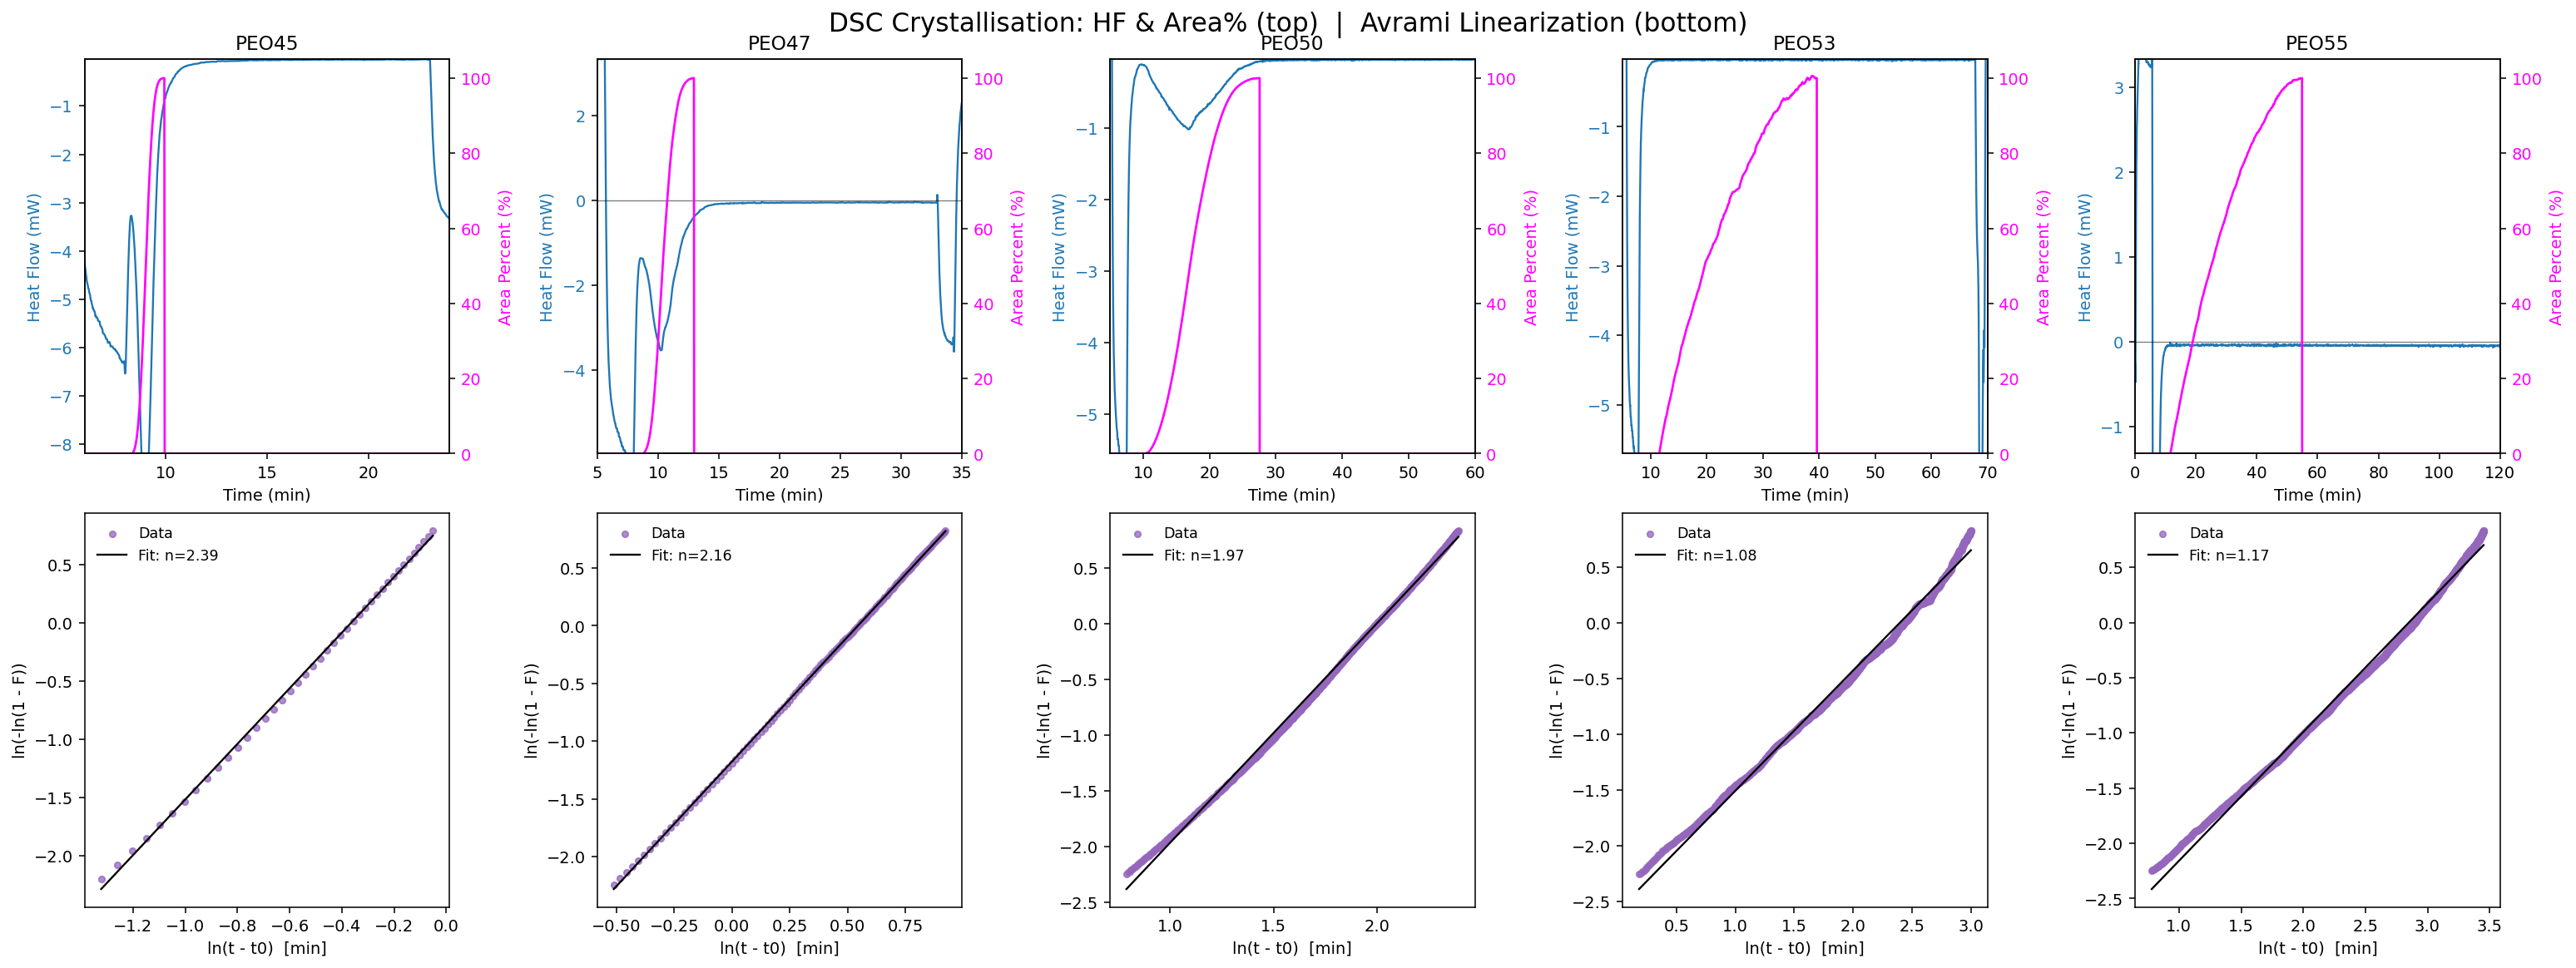


=== Avrami fit results (mid-fraction, onset at F >= 0.5%) ===
PEO45: n = 2.392,  Z = 2.397e+00  (time units: min^-2.391908320112145)
PEO47: n = 2.161,  Z = 3.088e-01  (time units: min^-2.161394202399468)
PEO50: n = 1.969,  Z = 1.950e-02  (time units: min^-1.9692425294615978)
PEO53: n = 1.080,  Z = 7.542e-02  (time units: min^-1.0796886160458443)
PEO55: n = 1.167,  Z = 3.598e-02  (time units: min^-1.1665958967479377)


In [12]:
# ---- create the big 2x5 figure ----
fig, axes = plt.subplots(2, 5, figsize=(22, 8), dpi=140, constrained_layout=True)

results = []  # collect (name, n, Z)

for j, fname in enumerate(files):
    path = os.path.join(base_dir, fname)
    df = load_dataset(path)
    t = df['Time/m'].to_numpy()
    HF = df['Heat_Flow/mW'].to_numpy()
    A  = df['Area/%'].to_numpy()

    # apply dataset-specific window
    tmin, tmax = time_windows[fname]
    m = (t >= tmin) & (t <= tmax)
    t_w, HF_w, A_w = t[m], HF[m], A[m]

    # ---------- TOP ROW: HF & Area% vs time (dual-axis) ----------
    axL = axes[0, j]
    axR = axL.twinx()
    axL.plot(t_w, HF_w, color='tab:blue', lw=1.2)
    axL.axhline(0, color='k', lw=0.7, alpha=0.5)
    axL.set_title(fname.replace("_cleaned.csv", ""))
    axL.set_xlabel("Time (min)")
    axL.set_ylabel("Heat Flow (mW)", color='tab:blue')
    axL.tick_params(axis='y', labelcolor='tab:blue')
    axL.set_xlim(tmin, tmax)
    # optional: a pleasant default for HF range
    lo = np.nanpercentile(HF_w, 2) if HF_w.size else -1
    hi = np.nanpercentile(HF_w, 98) if HF_w.size else 0
    if np.isfinite(lo) and np.isfinite(hi) and lo < hi:
        axL.set_ylim(lo, hi)

    axR.plot(t_w, A_w, color='magenta', lw=1.4)
    axR.set_ylabel("Area Percent (%)", color='magenta')
    axR.tick_params(axis='y', labelcolor='magenta')
    axR.set_ylim(0, 105)

    # ---------- BOTTOM ROW: Avrami linearization ----------
    axA = axes[1, j]
    n, Z, x, y, xx, yy = avrami_from_area(t_w, A_w, onset_thr, (mid_low, mid_high))
    if x.size > 0:
        axA.scatter(x, y, s=14, color='tab:purple', alpha=0.75, label='Data')
        axA.plot(xx, yy, color='black', lw=1.2, label=f"Fit: n={n:.2f}")
        axA.legend(frameon=False, fontsize=9)
        axA.set_xlabel("ln(t - t0)  [min]")
        axA.set_ylabel("ln(-ln(1 - F))")
        results.append((fname, n, Z))
    else:
        axA.text(0.5, 0.5, "Insufficient\nmid-fraction data",
                 ha='center', va='center', transform=axA.transAxes)
        axA.set_axis_off()
        results.append((fname, np.nan, np.nan))

plt.suptitle("DSC Crystallisation: HF & Area% (top)  |  Avrami Linearization (bottom)",
             fontsize=16, y=1.02)
plt.savefig("Avrami_Analysis.png", bbox_inches='tight', dpi=1000)
plt.show()

# ---- print numerical results ----
print("\n=== Avrami fit results (mid-fraction, onset at F >= 0.5%) ===")
for fname, n, Z in results:
    label = fname.replace("_cleaned.csv", "")
    if np.isnan(n):
        print(f"{label:>5s}: n = N/A, Z = N/A")
    else:
        print(f"{label:>5s}: n = {n:.3f},  Z = {Z:.3e}  (time units: min^{-n})")